# Mini-Project 8
## EM-algorithm for Gaussian Mixture Modeling 
## George Tzanetakeis
## CSC421
## Jiazhuo Jiang
## V00892165
This project is based on Chapter 20 Learning Probabilistic Models 


1. Generate Gaussian Mixture Model sample data using the make_blobs function: 
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
Create and plot a dataset with 3 blobs and 1000 samples. **(Basic - 2 points)** 
2. Fit a Gaussian Mixture Model using sklearn on your data and show that it works 
using plotting. **(Basic - 2 points)** 
3. Create your own version of the make_blobs function that create 2D Gaussian distributions 
with arbitrary covariance matrices (not just isotropic) and create a binary classification dataset 
in which one class consists of 3 blobs and the other consists class consists of 3 blobs. Plot 
the resulting dataset **(Expected - 2 points)** 
4. Implement GMM-based classification using the fit/predict functions of the GMM model in sklearn. 
You can use the following example as a guide: https://scikitlearn.org/0.15/auto_examples/mixture/plot_gmm_classifier.html 
but be aware that this example uses the Iris dataset and a single GMM model where each mixture component 
corresponds to a class. Instead you should use two separate GMM models one for each class. **(Expected - 2 points)** 
5. Implement the EM-algorithm for Gaussian Mixture Models (GMMs) from "scratch". Use the make_blobs and your own version to check that it works and provided plots showing the results. **(Advanced - 2 points)** 

In [13]:
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
import scipy

#1

In [3]:
X, y = make_blobs(n_samples=1000, centers=3, random_state=42)

#2

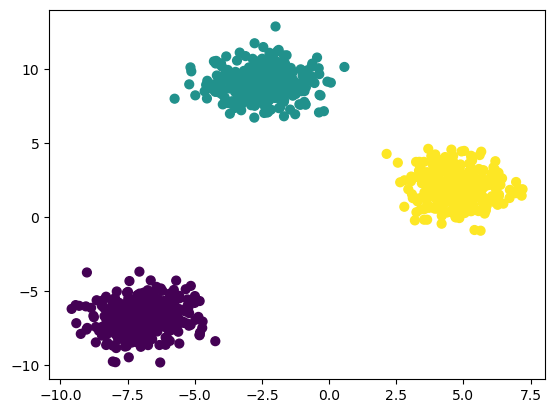

In [4]:
gmm = GaussianMixture(n_components=3).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plt.show()

#3

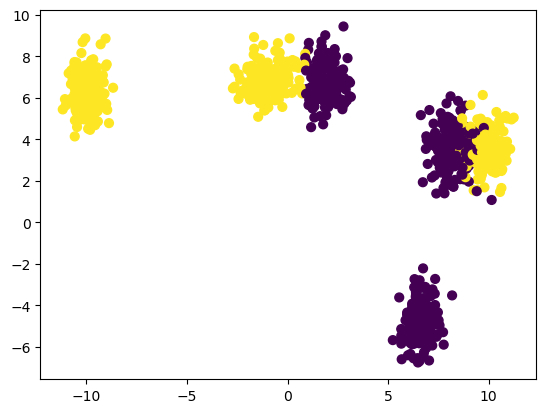

In [5]:
def my_make_blobs(sample=1000, std=0.5, center_box=(-10, 10), center=2, n_features=2, shuffle=True):
    
    blobs_num = 3
    data = np.zeros((sample, n_features + 2))
    index = 0
    for label in range(center * blobs_num):
        
        number = int(sample / center / blobs_num)
        if label == center * blobs_num - 1:
            number = sample - index
        
        mean = np.random.uniform(*center_box, n_features)
        conv = np.diag(np.random.rand(n_features))
        data[index: index+number:, :2] = np.random.multivariate_normal(mean, conv, number)
        data[index: index+number:, -2] = label // blobs_num
        data[index: index+number:, -1] = label - (label // blobs_num) * blobs_num

        index += number
    if shuffle:
        np.random.shuffle(data)
    return data[:, :2], data[:, -2], data[:, -1]

X, y, blob = my_make_blobs()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='viridis')
plt.show()

#4 

In [6]:
def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm.covariances_[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle)
        ax.add_patch(ell)
        ell.set_alpha(0.4)
        ell.set_color(color)

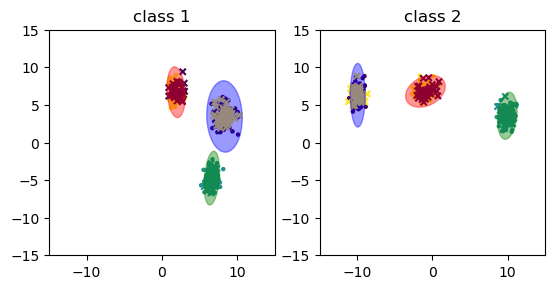

In [7]:
X_train, X_test, y_train, y_test, blob_train, blob_test = train_test_split(X, y, blob, test_size=0.25, random_state=42)

cls_num = 2
blob_num = 3
classifiers = [GaussianMixture(n_components=3) for _ in range(cls_num)]

fig, ax = plt.subplots(1, 2, subplot_kw={"aspect": "equal"})

for i in range(cls_num):
    classifiers[i].fit(X_train[y_train == i])
    make_ellipses(classifiers[i], ax[i])
    ax[i].scatter(X_train[y_train == i][:, 0], X_train[y_train == i][:, 1], marker=".", c=blob_train[y_train == i], s=20, cmap='viridis')
    
    predict = classifiers[i].predict(X_test[y_test == i])
    ax[i].scatter(X_test[y_test == i][:, 0], X_test[y_test == i][:, 1], marker="x", c=predict, s=20, cmap='viridis')
    ax[i].axis([-15, 15, -15, 15])
    ax[i].set_title(f"class {i+1}")

plt.show()

#5

In [16]:
class MyGMM:
    
    def __init__(self, n_components, dataset, feature=2, max_iter=1000):
        self.n_components = n_components
        self.max_iter = max_iter
        self.n_samples = len(dataset)
        self.dataset = dataset
        self.feature = feature

        self.mu = np.random.rand(n_components, feature)
        self.var = np.random.rand(n_components, feature)
        
        self.w = np.ones((self.n_samples, n_components)) / n_components
        self.pi = self.w.sum(axis=0) / self.w.sum()
        
        
    def update_w(self):
        pdfs = np.zeros(((self.n_samples, self.n_components)))
        for i in range(self.n_components):
            pdfs[:, i] = self.pi[i] * multivariate_normal.pdf(self.dataset, self.mu[i], np.diag(self.var[i]))
        self.w = pdfs / pdfs.sum(axis=1).reshape(-1, 1)
    
    def update_pi(self):
        self.pi = self.w.sum(axis=0) / self.w.sum()
        
    def update_mu(self):
        for i in range(self.n_components):
            self.mu[i] = np.average(self.dataset, axis=0, weights=self.w[:, i])
    
    def update_var(self):
        for i in range(self.n_components):
            self.var[i] = np.average((self.dataset - self.mu[i]) ** 2, axis=0, weights=self.w[:, i])
        
    def fit(self):
        for _ in range(self.max_iter):
            self.update_w()
            self.update_pi()
            self.update_mu()
            self.update_var()

In [9]:
def plot_clusters(X, y, mu, var):
    colors = ['b', 'g', 'r', "m", "c", "y"]
    n_clusters = len(mu)
    plt.figure(figsize=(10, 8))
    plt.axis([-10, 15, -10, 15])
    plt.scatter(X[:, 0], X[:, 1], s=5, c=y)
    ax = plt.gca()
    for i in range(n_clusters):
        ellipse = Ellipse(mu[i], 3 * var[i][0], 3 * var[i][1])
        ax.add_patch(ellipse)
        ellipse.set_alpha(0.4)
        ellipse.set_color(colors[i])
    

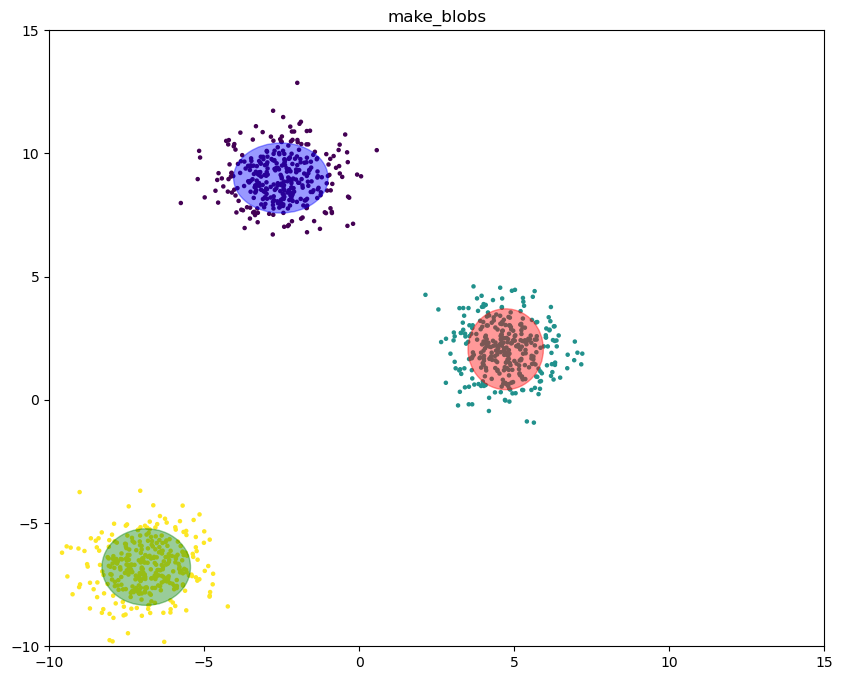

In [10]:
X, y = make_blobs(n_samples=1000, centers=3, random_state=42)
my_gmm = MyGMM(3, X)
my_gmm.fit()
plot_clusters(X, y, my_gmm.mu, my_gmm.var)
plt.title("make_blobs")
plt.show()

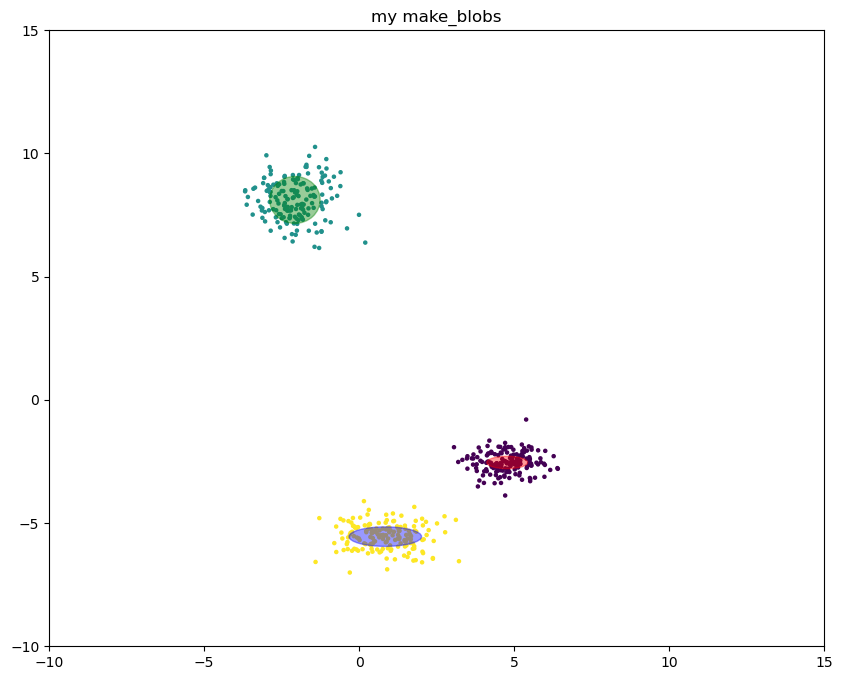

In [21]:
X, y, blob = my_make_blobs()
my_gmm = MyGMM(3, X[y==0])
my_gmm.fit()
plot_clusters(X[y==0], blob[y==0], my_gmm.mu, my_gmm.var)
plt.title("my make_blobs")
plt.show()